In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import pickle
import sys
sys.path.append('/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/src')
from utils import functions as fu 

## Modelo final 

En este archivo se presenta, de manera ordenada, el modelo conjunto que ha obtenido la mejor puntuación. Asimismo, se presentarán los modelos que lo componene en el siguiente orden: 

 1. Modelo ridge 
 2. Modelo Gradient Boosting 
 3. Modelo Catboost
 4. Modelo conjunto final: Stacked 
 5. Predicciones finales 



Antes que nada, importamos los datos limpios.

In [34]:
train_data=pd.read_csv("/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/src/data/data_clean/train_data_clean.csv")
test_data=pd.read_csv("/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/src/data/data_clean/test_data_clean.csv")


Aplicamos una transformación logarítmica tanto a las features como a la variable target. Separamos en train(80%) y test(20%).

In [5]:

def aplicar_logaritmos(df):
    df_copy = df.copy()
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values > 10 and all(df[col] > 0):
            df_copy[col] = np.log1p(df[col])
    return df_copy

In [6]:
train_data_log=aplicar_logaritmos(train_data)
test_data_log=aplicar_logaritmos(test_data)

In [14]:

X = train_data_log.iloc[:,:-1]
y = np.log1p(train_data['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Modelo Ridge 

rmse:  0.13132579534960798
Mean CV score (rmse):  0.1299481987495986
R-cuadrado: 0.91


<Figure size 1200x1200 with 0 Axes>

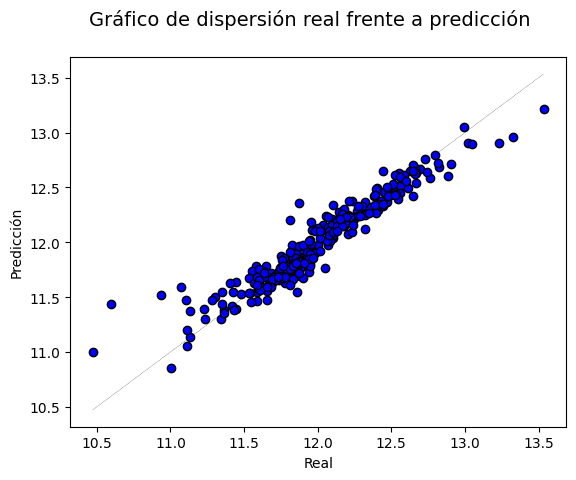

In [15]:
#Definimos el modelo
alphas_ = [20,25,30,35,40]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_, ))

#Entrenamos el modelo
model_ridge = ridge.fit(X_train,y_train)

#Predecimos
y_pred_ridge = model_ridge.predict(X_test)

#Evaluamos el modelo 
fu.rmse(y_pred_ridge,y_test)
fu.cross_validation_rmse(model_ridge,X_train,y_train)
fu.r_cuadrado(y_test,y_pred_ridge)
fu.real_vs_pred(y_test,y_pred_ridge)



2. Modelo Gradient boosting 

rmse:  0.13072852164715773
Mean CV score (rmse):  0.13099573781257065
R-cuadrado: 0.91


<Figure size 1200x1200 with 0 Axes>

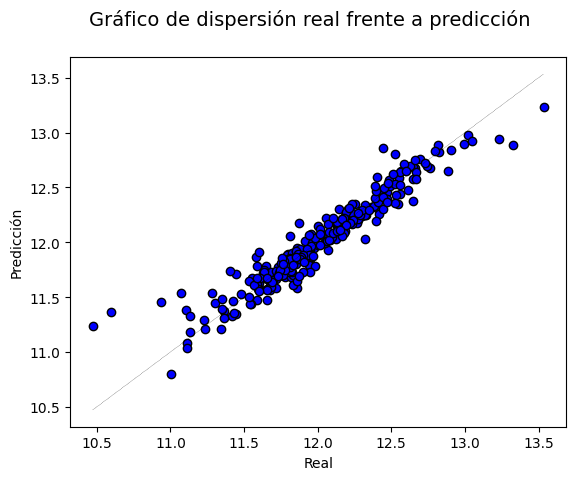

In [11]:
#Definimos el modelo 
param_grid = {
    'n_estimators': [400],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'loss': ['huber']
}
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

#Entrenamos el modelo 
grid_search.fit(X_train, y_train)
model_gbr = grid_search.best_estimator_

#Predecimos 
y_pred_gbr= model_gbr.predict(X_test)

#Evaluamos el modelo
fu.rmse(y_pred_gbr,y_test)
fu.cross_validation_rmse(model_gbr,X_train,y_train)
fu.r_cuadrado(y_test,y_pred_gbr)
fu.real_vs_pred(y_test,y_pred_gbr)




3. Modelo Catboost

rmse:  0.12394770488917181
0:	learn: 0.3941667	total: 1.51ms	remaining: 9.09s
200:	learn: 0.2336387	total: 197ms	remaining: 5.7s
400:	learn: 0.1729224	total: 484ms	remaining: 6.76s
600:	learn: 0.1473474	total: 687ms	remaining: 6.17s
800:	learn: 0.1331740	total: 898ms	remaining: 5.83s
1000:	learn: 0.1243031	total: 1.12s	remaining: 5.58s
1200:	learn: 0.1180858	total: 1.33s	remaining: 5.33s
1400:	learn: 0.1128233	total: 1.55s	remaining: 5.09s
1600:	learn: 0.1081308	total: 1.75s	remaining: 4.82s
1800:	learn: 0.1043159	total: 1.96s	remaining: 4.58s
2000:	learn: 0.1009225	total: 2.18s	remaining: 4.35s
2200:	learn: 0.0981391	total: 2.39s	remaining: 4.13s
2400:	learn: 0.0956621	total: 2.6s	remaining: 3.89s
2600:	learn: 0.0934794	total: 2.81s	remaining: 3.68s
2800:	learn: 0.0913383	total: 3.02s	remaining: 3.45s
3000:	learn: 0.0892119	total: 3.25s	remaining: 3.25s
3200:	learn: 0.0870576	total: 3.46s	remaining: 3.02s
3400:	learn: 0.0850792	total: 3.68s	remaining: 2.81s
3600:	learn: 0.0832473	tota

<Figure size 1200x1200 with 0 Axes>

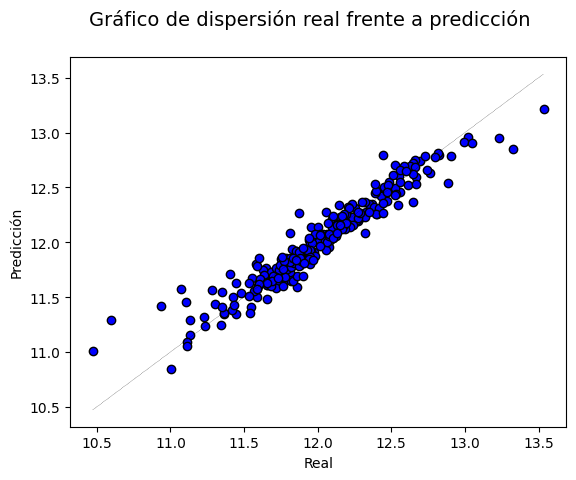

In [16]:
#Definimos el modelo 
params = {'iterations': 6000,
          'learning_rate': 0.0055,
          'depth': 4,
          'l2_leaf_reg': 5,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}
cat_f = CatBoostRegressor(**params)

#Entrenamos el mdoelo
model_catboost = cat_f.fit(X_train,y_train,
                     eval_set = (X_test,y_test),
                     verbose = False)
#Predecimos 
y_pred_catboost=model_catboost.predict(X_test)

#Evaluamos el modelo
fu.rmse(y_pred_catboost,y_test)
fu.cross_validation_rmse(model_catboost,X_train,y_train)
fu.r_cuadrado(y_test,y_pred_catboost)
fu.real_vs_pred(y_test,y_pred_catboost)




4. Modelo conjunto final: Stacked 

0:	learn: 0.3891449	total: 1.89ms	remaining: 11.3s
200:	learn: 0.2288224	total: 377ms	remaining: 10.9s
400:	learn: 0.1695363	total: 606ms	remaining: 8.46s
600:	learn: 0.1444191	total: 825ms	remaining: 7.41s
800:	learn: 0.1305072	total: 1.06s	remaining: 6.86s
1000:	learn: 0.1214842	total: 1.3s	remaining: 6.49s
1200:	learn: 0.1153111	total: 1.49s	remaining: 5.96s
1400:	learn: 0.1109670	total: 1.7s	remaining: 5.6s
1600:	learn: 0.1068481	total: 1.91s	remaining: 5.26s
1800:	learn: 0.1029564	total: 2.13s	remaining: 4.96s
2000:	learn: 0.0996705	total: 2.34s	remaining: 4.68s
2200:	learn: 0.0968399	total: 2.55s	remaining: 4.4s
2400:	learn: 0.0951318	total: 2.79s	remaining: 4.19s
2600:	learn: 0.0932815	total: 3.01s	remaining: 3.93s
2800:	learn: 0.0910856	total: 3.25s	remaining: 3.71s
3000:	learn: 0.0887828	total: 3.49s	remaining: 3.49s
3200:	learn: 0.0865334	total: 3.74s	remaining: 3.27s
3400:	learn: 0.0844479	total: 3.99s	remaining: 3.05s
3600:	learn: 0.0825128	total: 4.23s	remaining: 2.82s
380

<Figure size 1200x1200 with 0 Axes>

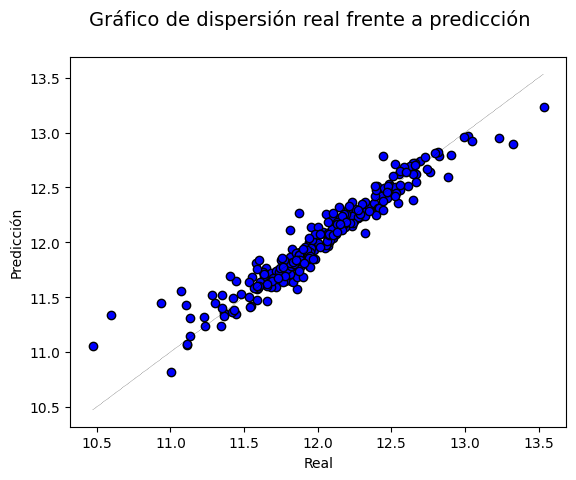

In [17]:
#Definimos el modelo 
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=175)
estimators = [
              
              ("Gradient Boosting Regressor", model_gbr),
              ("XGBoost1",xgb_model),
              ("Ridge",model_ridge),
              ("Catboost", model_catboost)
              
              ]
reg = LinearRegression()
model_stacked = StackingRegressor(estimators=estimators, final_estimator=reg)

# Entrenamos el modelo 
model_stacked= model_stacked.fit(X_train, y_train)
# Predecimos 
y_pred_stacked= model_stacked.predict(X_test)

#Evaluamos el modelo
fu.rmse(y_pred_stacked,y_test)
fu.cross_validation_rmse(model_stacked,X_train,y_train)
fu.r_cuadrado(y_test,y_pred_stacked)
fu.real_vs_pred(y_test,y_pred_stacked)



El gráfico anterior está representado en logaritmos, volvemos a tranformar los datos a partir de su exponencial para una mejor interpretción.

<Figure size 1200x1200 with 0 Axes>

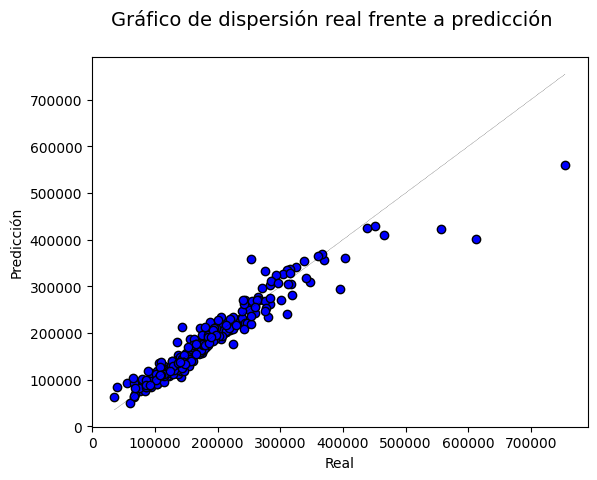

In [18]:
fu.real_vs_pred(np.exp(y_test)-1,np.exp(y_pred_stacked)-1)

Como vemos, la mayor parte del error del modelo se concentra en las casas más caras -a partir de los 400k, el error crece considerablemente, y siempre con el mismo sesgo: predice sistematicamente un valor inferior al valor real-. Una hipotesis plausible del porqué es que las casas de ese valor están subrepresentadas en el conjunto de entrenamiento. Sin embargo, hemos probado los mismos modelos aumentando el peso de las viviendas con un precio superior a 400k, y los resultados han sido peores, por lo que tomamos este modelo como el final. 

Una vez elegido el modelo final, lo volvemos a entrenar con todos los datos de train.

In [21]:
modelo_final= model_stacked.fit(X,y)

0:	learn: 0.3980788	total: 2.39ms	remaining: 14.4s
200:	learn: 0.2320438	total: 371ms	remaining: 10.7s
400:	learn: 0.1708819	total: 604ms	remaining: 8.44s
600:	learn: 0.1451696	total: 850ms	remaining: 7.64s
800:	learn: 0.1317490	total: 1.08s	remaining: 7.03s
1000:	learn: 0.1229486	total: 1.31s	remaining: 6.55s
1200:	learn: 0.1171655	total: 1.54s	remaining: 6.17s
1400:	learn: 0.1130247	total: 1.81s	remaining: 5.93s
1600:	learn: 0.1094242	total: 2.03s	remaining: 5.58s
1800:	learn: 0.1060693	total: 2.25s	remaining: 5.26s
2000:	learn: 0.1030340	total: 2.49s	remaining: 4.97s
2200:	learn: 0.1007948	total: 2.71s	remaining: 4.68s
2400:	learn: 0.0987155	total: 2.94s	remaining: 4.4s
2600:	learn: 0.0967585	total: 3.15s	remaining: 4.12s
2800:	learn: 0.0948804	total: 3.38s	remaining: 3.86s
3000:	learn: 0.0929422	total: 3.6s	remaining: 3.6s
3200:	learn: 0.0910065	total: 3.83s	remaining: 3.35s
3400:	learn: 0.0891183	total: 4.05s	remaining: 3.1s
3600:	learn: 0.0873646	total: 4.29s	remaining: 2.86s
380

### Guardamos el modelo

In [53]:

with open('modelo_final.pkl', 'wb') as archivo:
    pickle.dump(modelo_final, archivo)


La puntuación final ha sido de 0.12065.  
